In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Mon chemin vers le fichier : "/content/drive/MyDrive/EPSI/Annee 4/Atelier composant métier/TD/export.csv"
# un chemin du genre /content/drive/MyDrive/export.csv serait plus facile pour tous selon moi

In [3]:
#import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = 'drive/MyDrive/export.csv' # Remplacez ceci par votre CSV
#data = 'export.csv'

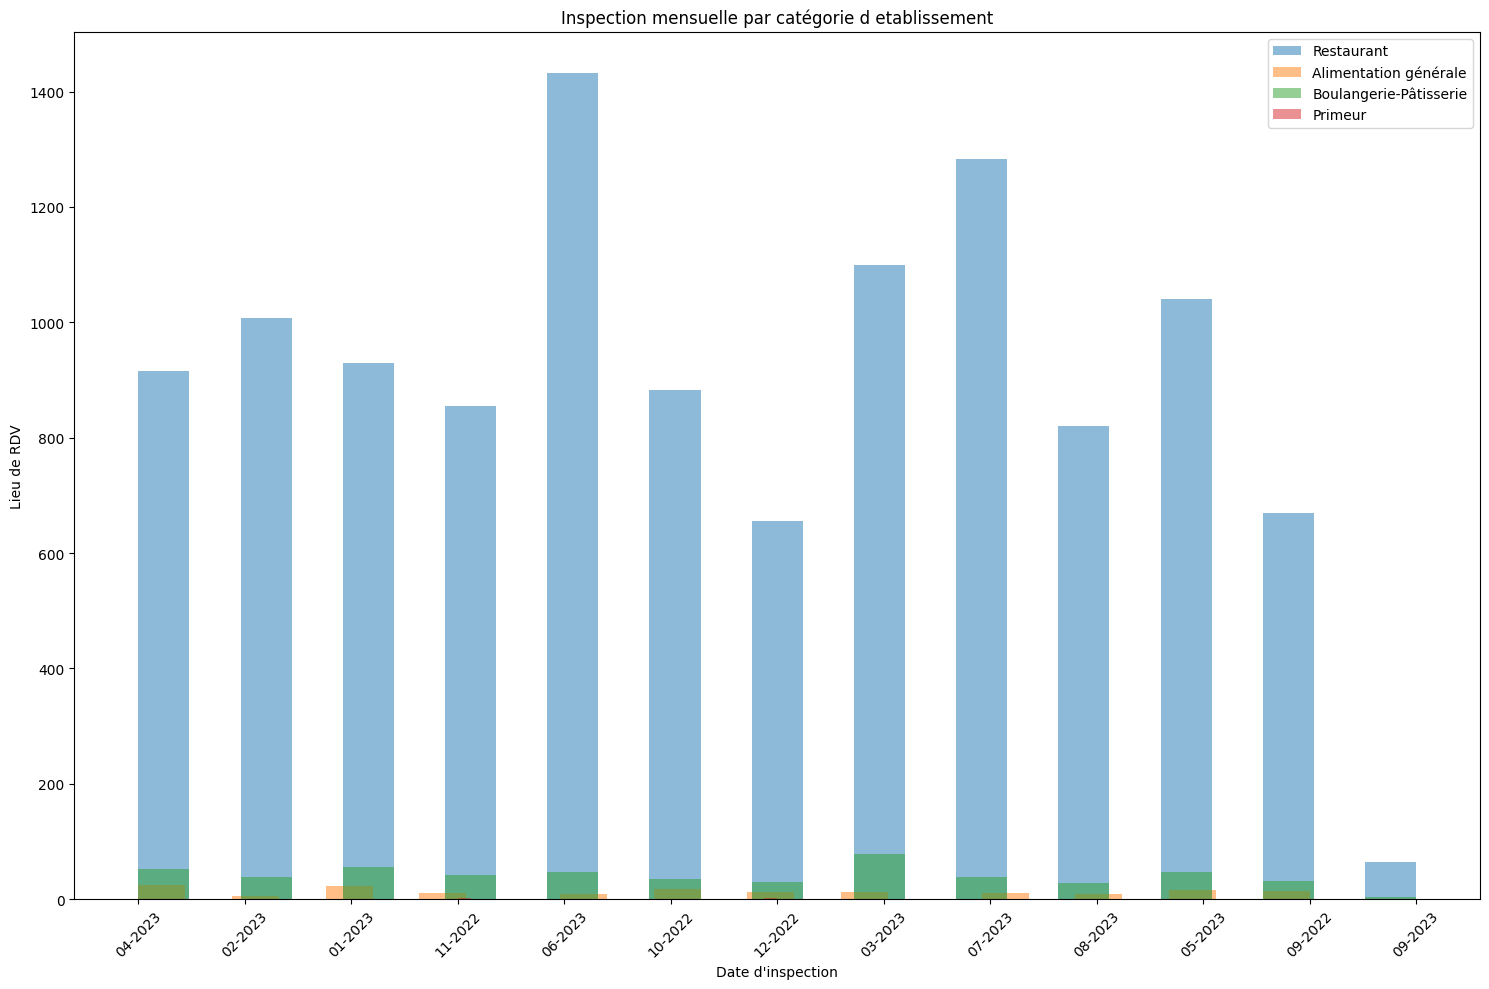

In [4]:
#Nettoyage du dataset
df = pd.read_csv(data, sep=';')

df['Date_inspection'] = pd.to_datetime(df['Date_inspection'], utc=True)
df['mois_annee'] = df['Date_inspection'].dt.strftime('%m-%Y')

# Extraire les lieux de RDV
lieux = df['APP_Libelle_activite_etablissement']

# Hypothèse 1
# Extraire les catégories uniques
#categories = df['filtre'].unique()
categories_to_include = ['Restaurant', 'Alimentation générale', 'Boulangerie-Pâtisserie', 'Primeur']

# Filtrer le DataFrame pour inclure uniquement les lignes correspondant à ces trois catégories
filtered_df = df[df['filtre'].isin(categories_to_include)]


# Créez un nuage de points distinct pour chaque catégorie
plt.figure(figsize=(15, 10))

for category in categories_to_include:
    # Filtrer le DataFrame pour obtenir les données de la catégorie actuelle
    subset = filtered_df[filtered_df['filtre'] == category]

    # Créer un nuage de points pour cette catégorie
    #plt.scatter(subset['mois_annee'], subset['APP_Libelle_activite_etablissement'], label=category, alpha=0.5)

    # Créer un histogramme pour cette catégorie
    plt.hist(subset['mois_annee'], bins=25, label=category, alpha=0.5)


plt.xticks(rotation=45)
plt.xlabel("Date d'inspection")
plt.ylabel('Lieu de RDV')
plt.title('Inspection mensuelle par catégorie d etablissement')
plt.legend()  # Affiche la légende des catégories
plt.tight_layout()
plt.show()

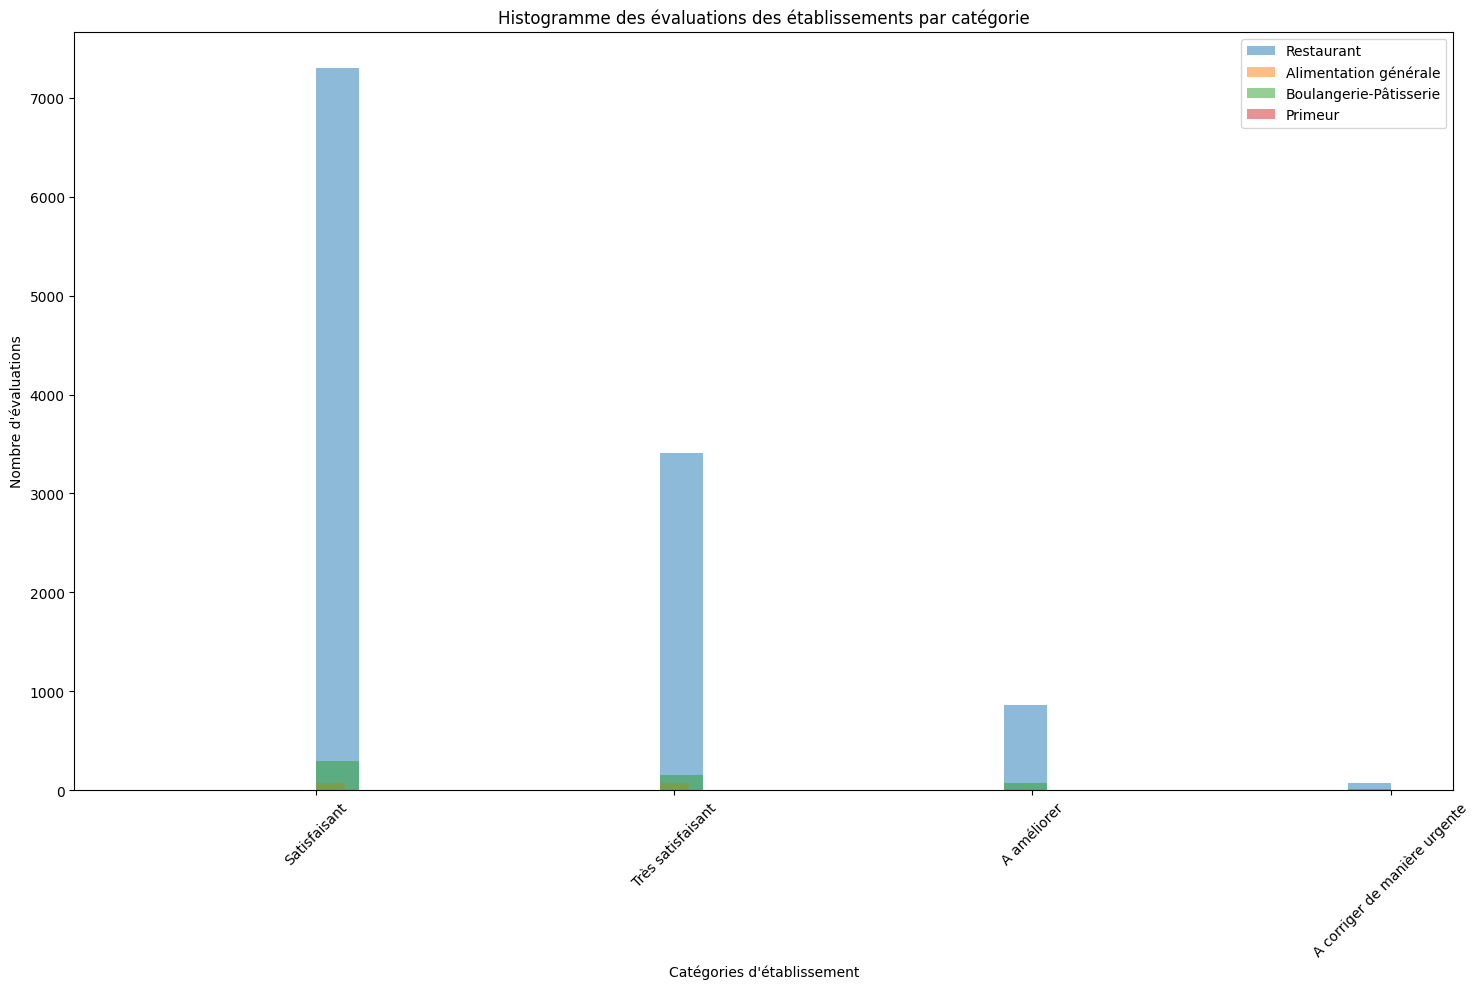

In [5]:
# Hypothèse 2
#Est-ce que l’évaluation (Synthese_eval_sanit) diffère selon le type d'établissement (APP_Libelle_activite_etablissement) ?
evaluation_to_include = ['Satisfaisant', 'Très satisfaisant', 'A améliorer', 'A corriger de manière urgente']
categories_to_include = ['Restaurant', 'Alimentation générale', 'Boulangerie-Pâtisserie', 'Primeur']

# Filtrer le DataFrame pour inclure uniquement les lignes correspondant à ces trois catégories
filtered_df = df[df['filtre'].isin(categories_to_include)]

# Filtrer le DataFrame pour inclure uniquement les évaluations à inclure
filtered_df = filtered_df[filtered_df['Synthese_eval_sanit'].isin(evaluation_to_include)]

# Créer un nuage de points distinct pour chaque catégorie
plt.figure(figsize=(15, 10))

for category in categories_to_include:
    # Filtrer le DataFrame pour obtenir les données de la catégorie actuelle
    subset = filtered_df[filtered_df['filtre'] == category]

    # Créer un nuage de points (ou un histogramme) pour cette catégorie
    plt.hist(subset['Synthese_eval_sanit'], bins=25, label=category, alpha=0.5)
    #plt.scatter(subset['filtre'], subset['Synthese_eval_sanit'], label=category, alpha=0.5)


plt.xticks(rotation=45)
plt.xlabel("Catégories d'établissement")
plt.ylabel("Nombre d'évaluations")
plt.title("Histogramme des évaluations des établissements par catégorie")
plt.legend()  # Affiche la légende des catégories
plt.tight_layout()
plt.show()


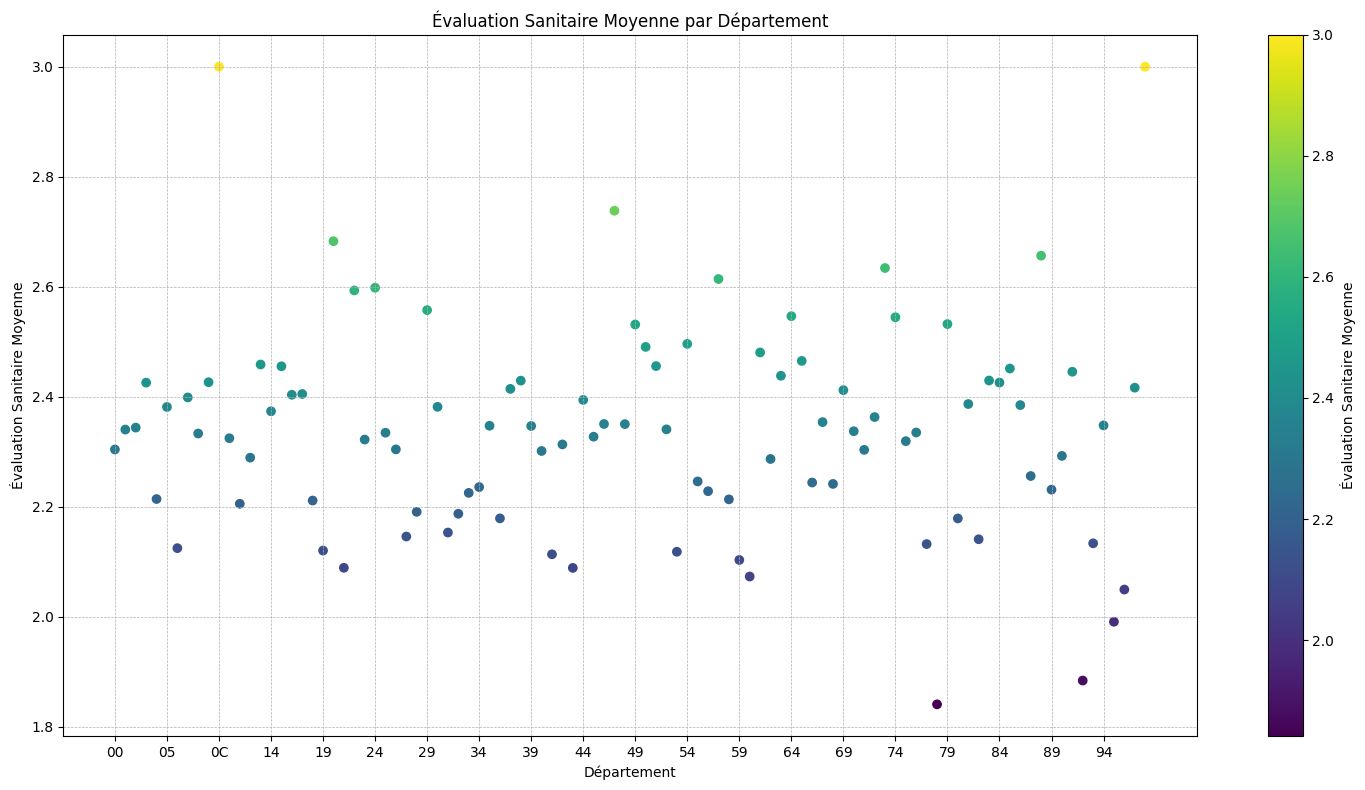

In [6]:
#Hypothèse 3
#Est-ce que le lieu (Libelle_commune ou/et Code_postal) joue sur la note (Synthese_eval_sanit) ?

import pandas as pd
import matplotlib.pyplot as plt

# Lire le CSV
df = pd.read_csv(data, sep=';')

# Convertir la colonne Synthese_eval_sanit en forme numérique
df['Synthese_eval_sanit_num'] = df['Synthese_eval_sanit'].map({
    'A améliorer': 1,
    'Satisfaisant': 2,
    'Très satisfaisant': 3
})

# Récupérer les deux premiers chiffres du code postal pour identifier le département
df['Departement'] = df['Code_postal'].astype(str).str[:2]

# Grouper par département et obtenir la moyenne des évaluations
df_grouped = df.groupby('Departement')['Synthese_eval_sanit_num'].mean().reset_index()

# Trier les données par département pour un affichage clair
df_grouped = df_grouped.sort_values('Departement')

# Créer le nuage de points
plt.figure(figsize=(15, 8))
plt.scatter(df_grouped['Departement'], df_grouped['Synthese_eval_sanit_num'], c=df_grouped['Synthese_eval_sanit_num'], cmap='viridis')

# Labelliser les axes et donner un titre
plt.ylabel("Évaluation Sanitaire Moyenne")
plt.xlabel("Département")
plt.title("Évaluation Sanitaire Moyenne par Département")
plt.colorbar(label='Évaluation Sanitaire Moyenne')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Espacer les étiquettes de l'axe des x
plt.xticks(df_grouped['Departement'].iloc[::5])  # Affiche une étiquette tous les 5 départements

# Afficher le graphique
plt.tight_layout()
plt.show()



In [ ]:
# Modélisation


R^2: 0.05455428865160705


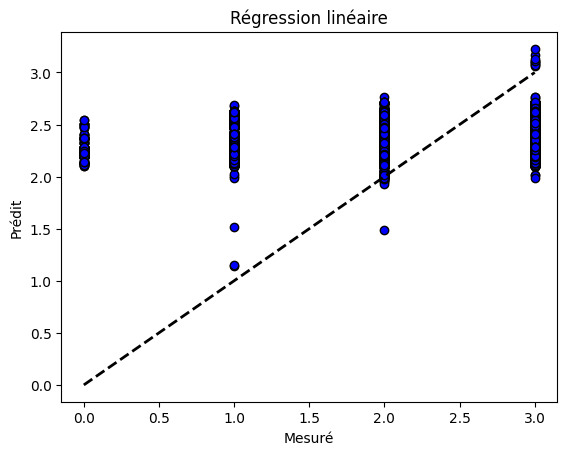

In [7]:
#Régression linéaire
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import io


df = pd.read_csv(data, sep=';')

# Suppression des caractères non numériques de la colonne 'SIRET'
df['SIRET'] = df['SIRET'].str.replace(r'\D', '', regex=True)

# Filtrage du DataFrame pour ne conserver que les colonnes désirées
df_filtered = df[["SIRET","Synthese_eval_sanit", "filtre", "ods_type_activite"]].copy()


# Conversion de "Synthese_eval_sanit" en variable numérique.
df_filtered["Synthese_eval_sanit"] = df_filtered["Synthese_eval_sanit"].map({
    "Très satisfaisant": 3,
    "Satisfaisant": 2,
    "A améliorer": 1,
    "A corriger de manière urgente": 0
})

# Conversion de "ods_type_activite" et "filtre" en variables dummies pour le modèle.
df_dummies = pd.get_dummies(df_filtered, columns=["ods_type_activite", "filtre"], drop_first=True)

#Nettoie les valeurs de la colonne Synthese_eval_sanit
df_dummies["Synthese_eval_sanit"].isna().sum()
df_dummies = df_dummies.dropna(subset=["Synthese_eval_sanit"])

# Mise en place de la régression linéaire
X = df_dummies.drop(columns=["Synthese_eval_sanit"])
y = df_dummies["Synthese_eval_sanit"]

model = LinearRegression()
model.fit(X, y)

# Prédictions et calcul du R^2
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Affichage du R^2
print(f"R^2: {r2}")

# Affichage du graphique
plt.scatter(y, y_pred, color='blue', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Mesuré')
plt.ylabel('Prédit')
plt.title('Régression linéaire')
plt.show()

Accuracy: 0.5472


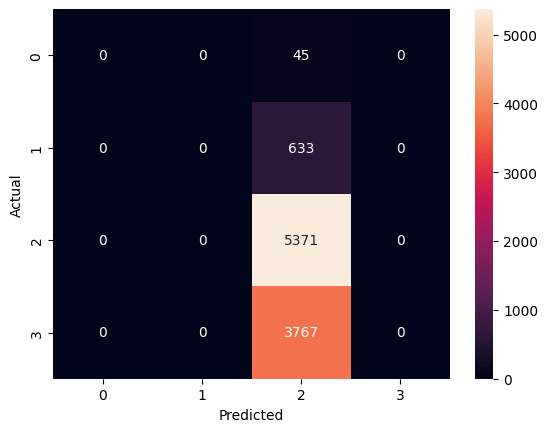

In [8]:
#Régression logistique :

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Création du DataFrame à partir du CSV
df = pd.read_csv(data, sep=';')

# Suppression des caractères non numériques de la colonne 'SIRET'
df['SIRET'] = df['SIRET'].str.replace(r'\D', '', regex=True)

df = df[['SIRET', 'Synthese_eval_sanit', 'filtre', 'ods_type_activite']]

# Transformation de la colonne Synthese_eval_sanit en valeurs numériques
df['Synthese_eval_sanit'] = df['Synthese_eval_sanit'].map({
    'Satisfaisant': 2,
    'Très satisfaisant': 3,
    'A améliorer': 1,
    'A corriger de manière urgente':0
}).fillna(df['Synthese_eval_sanit'])

# One-hot encoding pour les variables catégorielles
df = pd.get_dummies(df, columns=['filtre', 'ods_type_activite'], drop_first=True)

# Séparation des données en ensemble d'apprentissage et de test
X = df.drop('Synthese_eval_sanit', axis=1)
y = df['Synthese_eval_sanit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Entraînement du modèle de régression logistique
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [15]:
  # Random Forest
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Simulons la lecture de vos données
# df = pd.read_csv('votre_chemin_de_fichier.csv')
df = pd.read_csv(data, sep=';')

# Split en données d'entraînement et de test
X = df.drop('Synthese_eval_sanit', axis=1)
y = df['Synthese_eval_sanit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Traiter toutes les colonnes catégorielles avec LabelEncoder
label_encoders = {}  # Pour conserver les encodeurs pour une utilisation ultérieure

for col in X_train.columns:
    if X_train[col].dtype == 'object':  # Si colonne catégorielle
        le = LabelEncoder()

        # Ajustez l'encodeur sur l'ensemble d'entraînement
        le.fit(X_train[col])

        # Conservez uniquement les étiquettes présentes dans les données d'entraînement
        X_train[col] = X_train[col].map(lambda s: s if s in le.classes_ else '<Unknown>')
        X_test[col] = X_test[col].map(lambda s: s if s in le.classes_ else '<Unknown>')

        # Ajoutez la catégorie <Unknown> pour gérer les étiquettes inconnues
        le.classes_ = np.append(le.classes_, '<Unknown>')

        # Transformez les données
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

        # Conservez l'encodeur
        label_encoders[col] = le

# Entraîner le modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédire avec rf.predict(X_test)
y_pred = rf.predict(X_test)


# Calcul de l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred, zero_division=1)
print("Rapport de classification :")
print(class_report)




Accuracy: 0.4389
Matrice de confusion :
[[   8    0   61  356]
 [   0    0    2   22]
 [   1    0  555 3038]
 [   1    0  191 2309]]
Rapport de classification :
                               precision    recall  f1-score   support

                  A améliorer       0.80      0.02      0.04       425
A corriger de manière urgente       1.00      0.00      0.00        24
                 Satisfaisant       0.69      0.15      0.25      3594
            Très satisfaisant       0.40      0.92      0.56      2501

                     accuracy                           0.44      6544
                    macro avg       0.72      0.27      0.21      6544
                 weighted avg       0.59      0.44      0.36      6544

